Processing files with parameters: type=act, img=beta, mask=VS, denoise=base
Data saved to multiecho_data_act_beta_VS_base.csv
Found data for 42 subjects

Sample of the data:
    subject  headcoil      mb1me1      mb3me1      mb6me1      mb1me4  \
7     10017        64  245.809879  -33.401003  -59.411007 -192.291345   
0     10024        64   51.505184  216.723902  -43.077833  301.659488   
19    10035        64   63.785181   -4.770408   58.702194  256.401259   
20    10041        64  116.056601    1.490057   49.606862  109.906853   
26    10043        64  -25.623388  355.151709  249.998314  374.413217   

        mb3me4      mb6me4  
7    94.342661 -455.284310  
0   228.203450  215.914338  
19   39.646107  -12.061903  
20   39.833826  244.574431  
26  230.452505   96.114009  

Headcoil counts:
64-channel: 24
20-channel: 18

Creating bar plots...
Plot saved as 'multiecho_plots_act_beta_VS_base.png'


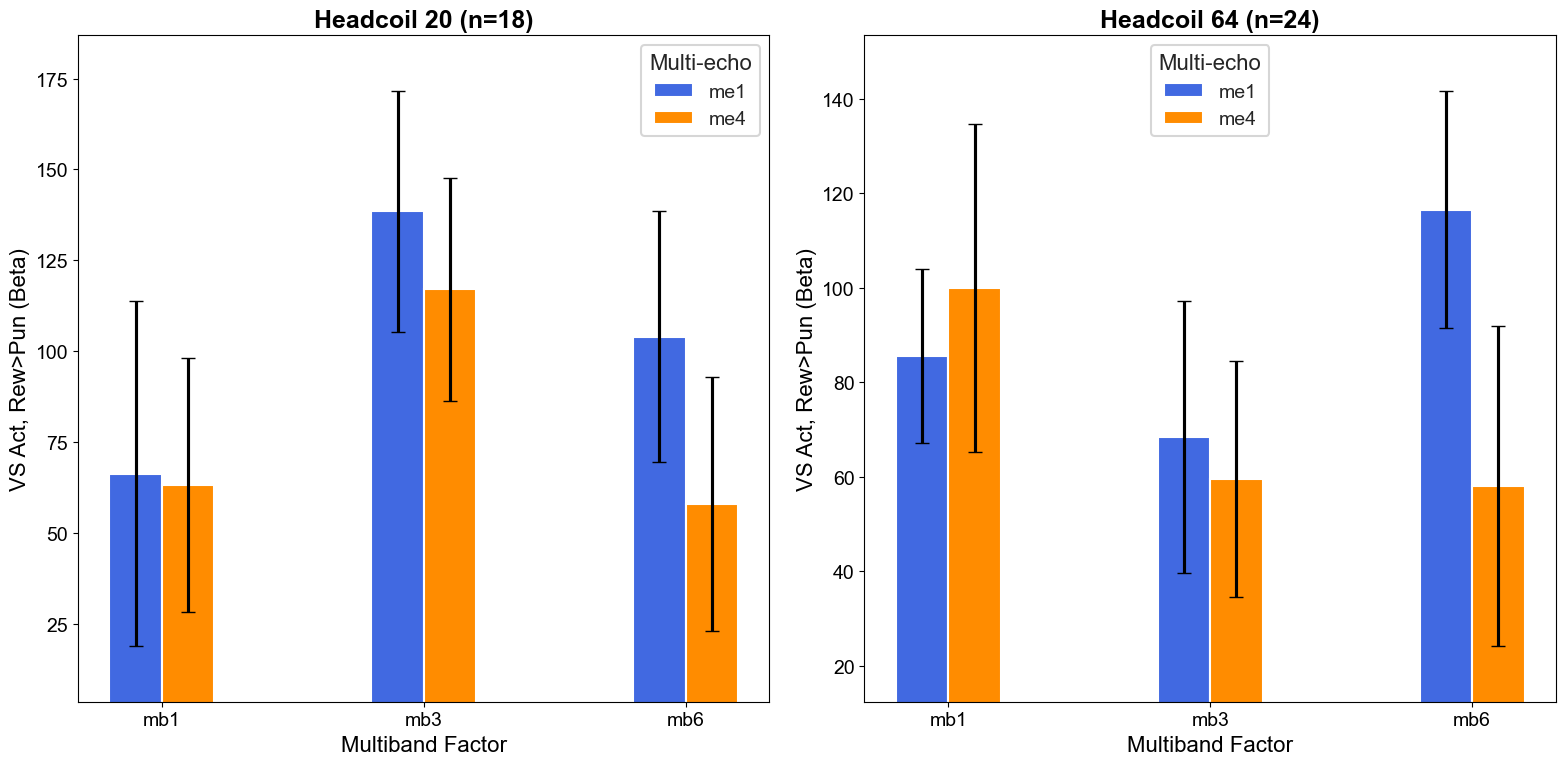

In [1]:
# VS Act, Rew>Pun, Beta
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act"
IMG_VALUE = "beta"  # e.g., "beta"
MASK_VALUE = "VS"   # e.g., "VS"
DENOISE_VALUE = "base"  # e.g., "base"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VS Act, Rew>Pun (Beta)', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

Processing files with parameters: type=act, img=zstat, mask=VS, denoise=base
Data saved to multiecho_data_act_zstat_VS_base.csv
Found data for 42 subjects

Sample of the data:
    subject  headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
5     10017        64  0.198120 -0.070155 -0.176612 -0.145148  0.117297   
14    10024        64  0.159562  0.645702 -0.215139  0.541546  0.716730   
25    10035        64  0.165379  0.012742  0.188826  0.507736  0.109783   
28    10041        64  0.207848  0.016244  0.165816  0.171276  0.108688   
3     10043        64  0.039013  1.243344  1.105695  0.471506  0.697493   

      mb6me4  
5  -0.575953  
14  0.747719  
25 -0.033795  
28  0.790779  
3   0.303748  

Headcoil counts:
64-channel: 24
20-channel: 18

Creating bar plots...
Plot saved as 'multiecho_plots_act_zstat_VS_base.png'


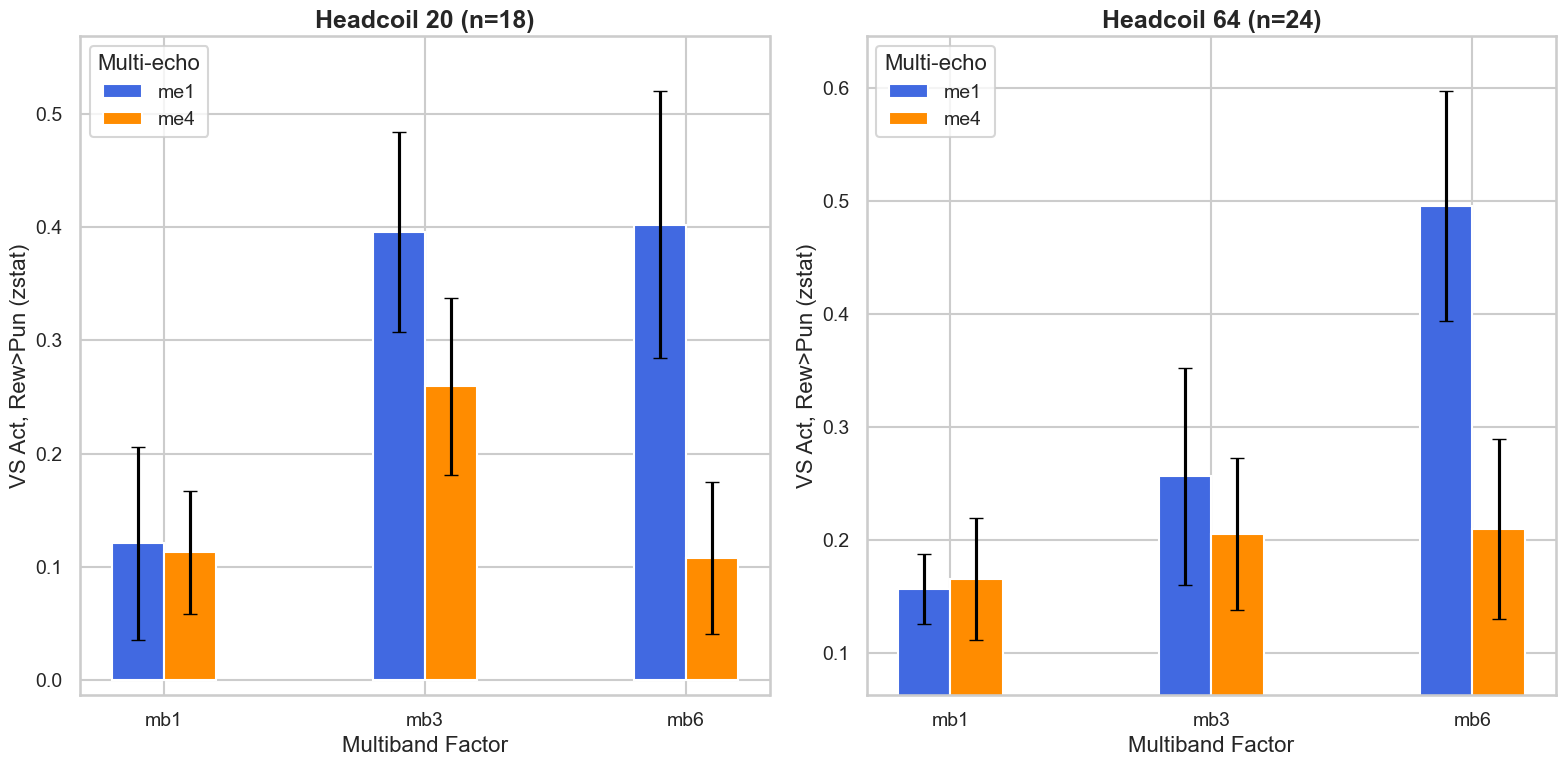

In [2]:
# VS Act, Rew>Pun, zstat
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act"
IMG_VALUE = "zstat"  # e.g., "beta"
MASK_VALUE = "VS"   # e.g., "VS"
DENOISE_VALUE = "base"  # e.g., "base"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VS Act, Rew>Pun (zstat)', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

Processing files with parameters: type=act, img=tsnr, mask=VS, denoise=base
Data saved to multiecho_data_act_tsnr_VS_base.csv
Found data for 42 subjects

Sample of the data:
    subject  headcoil      mb1me1      mb3me1      mb6me1      mb1me4  \
9     10017        64   98.468008  101.082365   89.113103  126.669046   
30    10024        64   89.921802  101.068596  101.829283  111.832313   
36    10035        64  114.323338  105.055642   90.190901  138.917720   
12    10041        64   94.474556   91.302075   76.609985   98.700391   
33    10043        64  114.856834  105.939600  108.623690  124.660089   

        mb3me4     mb6me4  
9   115.327378  86.495290  
30  113.880360  94.487234  
36  117.146918  96.039558  
12   89.956446  90.442086  
33  104.845022  88.063153  

Headcoil counts:
64-channel: 24
20-channel: 18

Creating bar plots...
Plot saved as 'multiecho_plots_act_tsnr_VS_base.png'


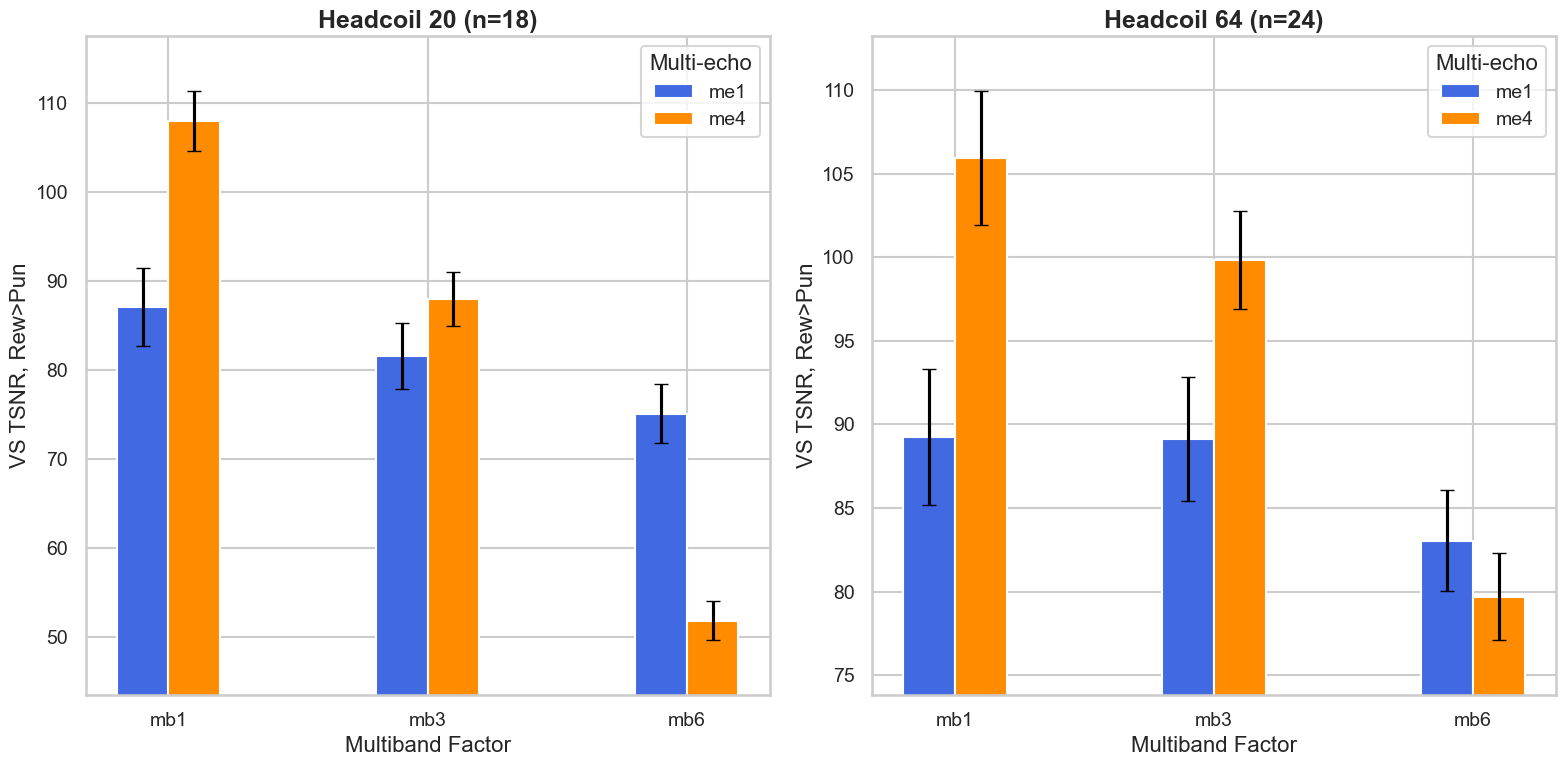

In [3]:
# VS TSNR, Rew>Pun
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act"
IMG_VALUE = "tsnr"  # e.g., "beta"
MASK_VALUE = "VS"   # e.g., "VS"
DENOISE_VALUE = "base"  # e.g., "base"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VS TSNR, Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

Processing files with parameters: type=act, img=tsnr, mask=VMPFC, denoise=base
Data saved to multiecho_data_act_tsnr_VMPFC_base.csv
Found data for 42 subjects

Sample of the data:
    subject  headcoil      mb1me1      mb3me1      mb6me1      mb1me4  \
38    10017        64   92.764439  103.486177   93.208293  111.566858   
11    10024        64   96.562068  106.675992  108.169497   97.159912   
27    10035        64  147.674807  148.346095  125.460717  132.988886   
29    10041        64  109.578625   96.607675   83.072306   65.537226   
2     10043        64  117.097093  106.711438  125.676406  124.220981   

        mb3me4      mb6me4  
38   96.743824   82.534756  
11  108.988943  105.860960  
27  127.098923  124.865261  
29   72.470341  108.679150  
2   100.134731   99.489811  

Headcoil counts:
64-channel: 24
20-channel: 18

Creating bar plots...
Plot saved as 'multiecho_plots_act_tsnr_VMPFC_base.png'


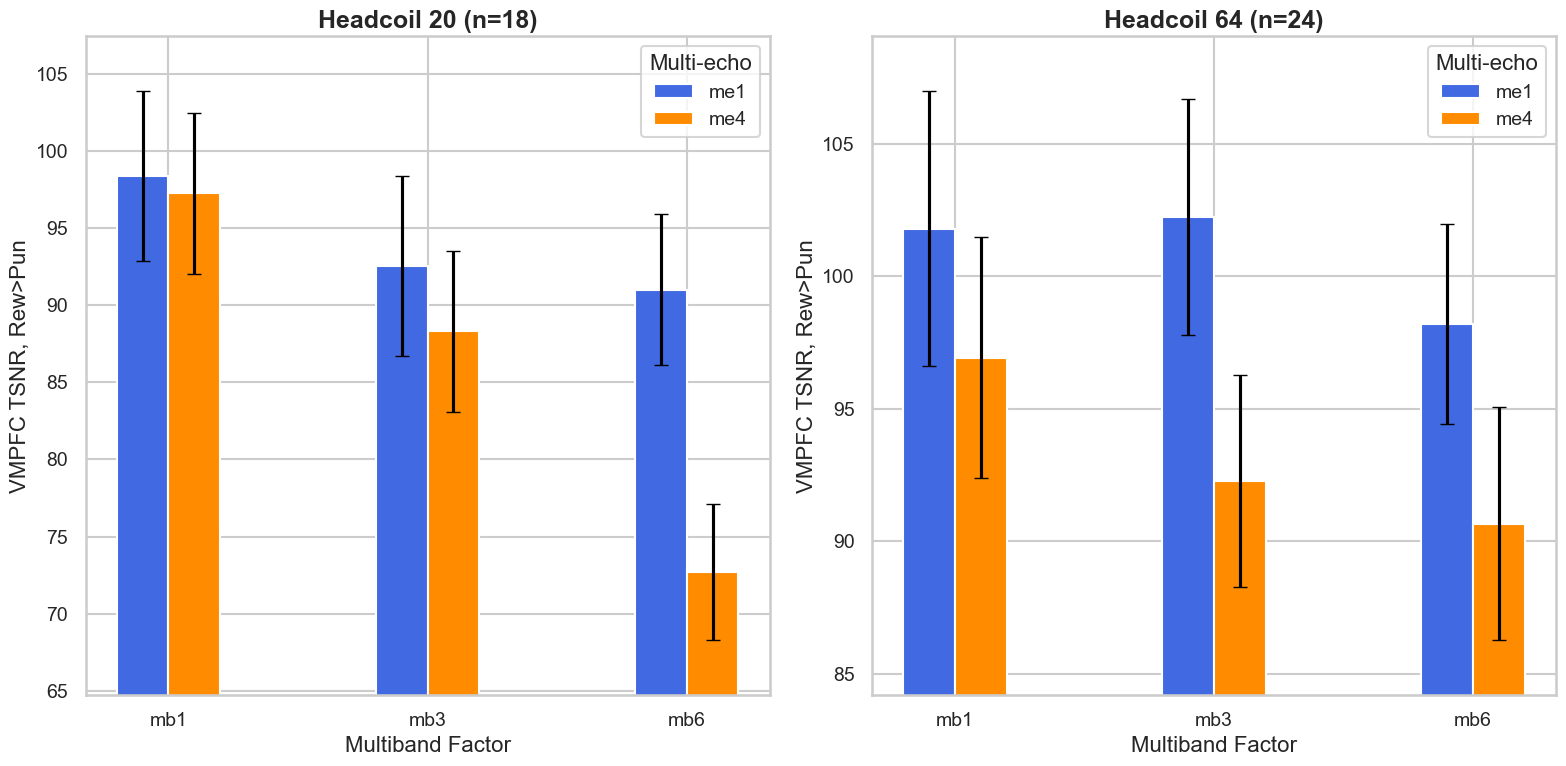

In [4]:
# VMPFC TSNR
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act"
IMG_VALUE = "tsnr"  # e.g., "beta"
MASK_VALUE = "VMPFC"   # e.g., "VS"
DENOISE_VALUE = "base"  # e.g., "base"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VMPFC TSNR, Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

Processing files with parameters: type=act, img=beta, mask=VMPFC, denoise=base
Data saved to multiecho_data_act_beta_VMPFC_base.csv
Found data for 42 subjects

Sample of the data:
    subject  headcoil       mb1me1      mb3me1      mb6me1      mb1me4  \
29    10017        64 -1195.574690  442.186628 -484.355767  536.258364   
2     10024        64  -277.995885  -34.193436 -142.470820  296.785679   
20    10035        64    51.341721   93.504021  195.372258   71.288997   
19    10041        64  -136.375101   48.929177   16.908278  120.772445   
14    10043        64  -492.054776  182.366555  155.257054  345.482364   

        mb3me4      mb6me4  
29 -603.878903  196.185988  
2   249.137970  208.670450  
20   86.177200  226.859307  
19 -469.151796   77.188762  
14  107.250584   49.894122  

Headcoil counts:
64-channel: 24
20-channel: 18

Creating bar plots...
Plot saved as 'multiecho_plots_act_beta_VMPFC_base.png'


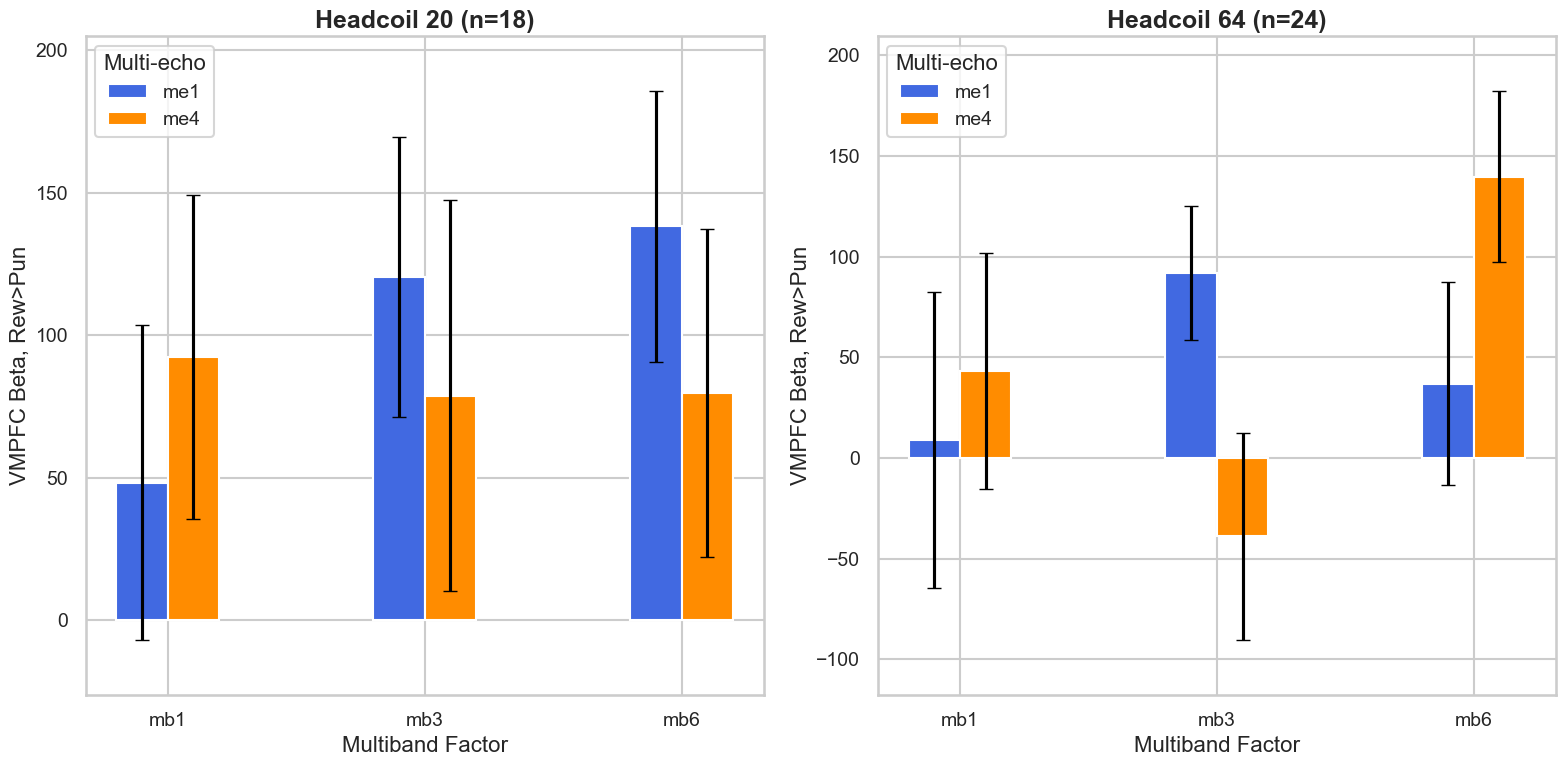

In [5]:
# VMPFC Act Rew>Pun, Beta
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta"  # e.g., "beta" "zstat" "tsnr"
MASK_VALUE = "VMPFC"   # e.g., "VS" "VMPFC"
DENOISE_VALUE = "base"  # e.g., "base" "tedana"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VMPFC Beta, Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

Processing files with parameters: type=act, img=zstat, mask=VMPFC, denoise=base
Data saved to multiecho_data_act_zstat_VMPFC_base.csv
Found data for 42 subjects

Sample of the data:
    subject  headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
2     10017        64 -0.922991  0.517057 -0.691013  0.501245 -0.755322   
37    10024        64 -0.645634 -0.138137 -0.533142  0.748278  0.843661   
13    10035        64  0.052803  0.449033  0.905423  0.188101  0.374602   
41    10041        64 -0.296046  0.165610  0.050039  0.280073 -1.095805   
21    10043        64 -1.057709  0.761375  0.724883  0.780460  0.388867   

      mb6me4  
2   0.272376  
37  0.812291  
13  1.108119  
41  0.304279  
21  0.216533  

Headcoil counts:
64-channel: 24
20-channel: 18

Creating bar plots...
Plot saved as 'multiecho_plots_act_zstat_VMPFC_base.png'


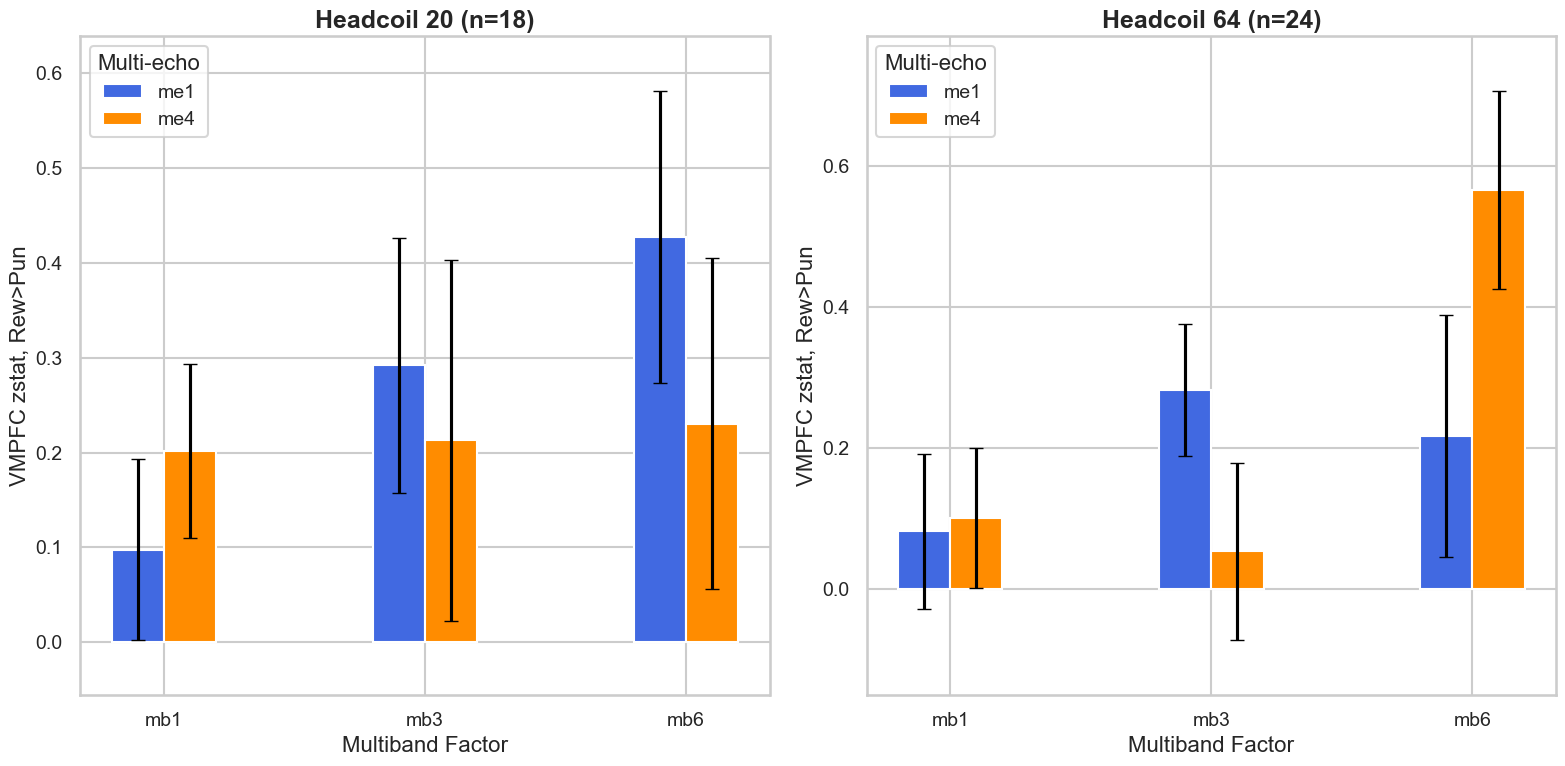

In [6]:
# VMPFC Act Rew>Pun, zstat
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act" "ppi_seed-VS_thr5"
IMG_VALUE = "zstat"  # e.g., "beta" "zstat" "tsnr"
MASK_VALUE = "VMPFC"   # e.g., "VS" "VMPFC"
DENOISE_VALUE = "base"  # e.g., "base" "tedana"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VMPFC zstat, Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

Processing files with parameters: type=ppi_seed-VS_thr5, img=beta, mask=VS, denoise=base
Data saved to multiecho_data_ppi_seed-VS_thr5_beta_VS_base.csv
Found data for 42 subjects

Sample of the data:
    subject  headcoil     mb1me1    mb3me1    mb6me1     mb1me4     mb3me4  \
16    10017        64 -37.090173 -8.234065 -4.097725 -53.320430  20.409584   
34    10024        64  -1.834136 -1.704207 -0.427586   8.032541   1.290515   
12    10035        64   3.126350 -1.605546 -2.283422   0.876367   2.400902   
24    10041        64  -3.240873  1.210604  0.248853  -3.915361  -0.753581   
9     10043        64  -3.603713 -0.305914  1.095516   1.638411  -0.725906   

      mb6me4  
16 -6.513016  
34 -0.310550  
12 -0.656202  
24 -1.318663  
9  -1.034924  

Headcoil counts:
64-channel: 24
20-channel: 18

Creating bar plots...
Plot saved as 'multiecho_plots_ppi_seed-VS_thr5_beta_VS_base.png'


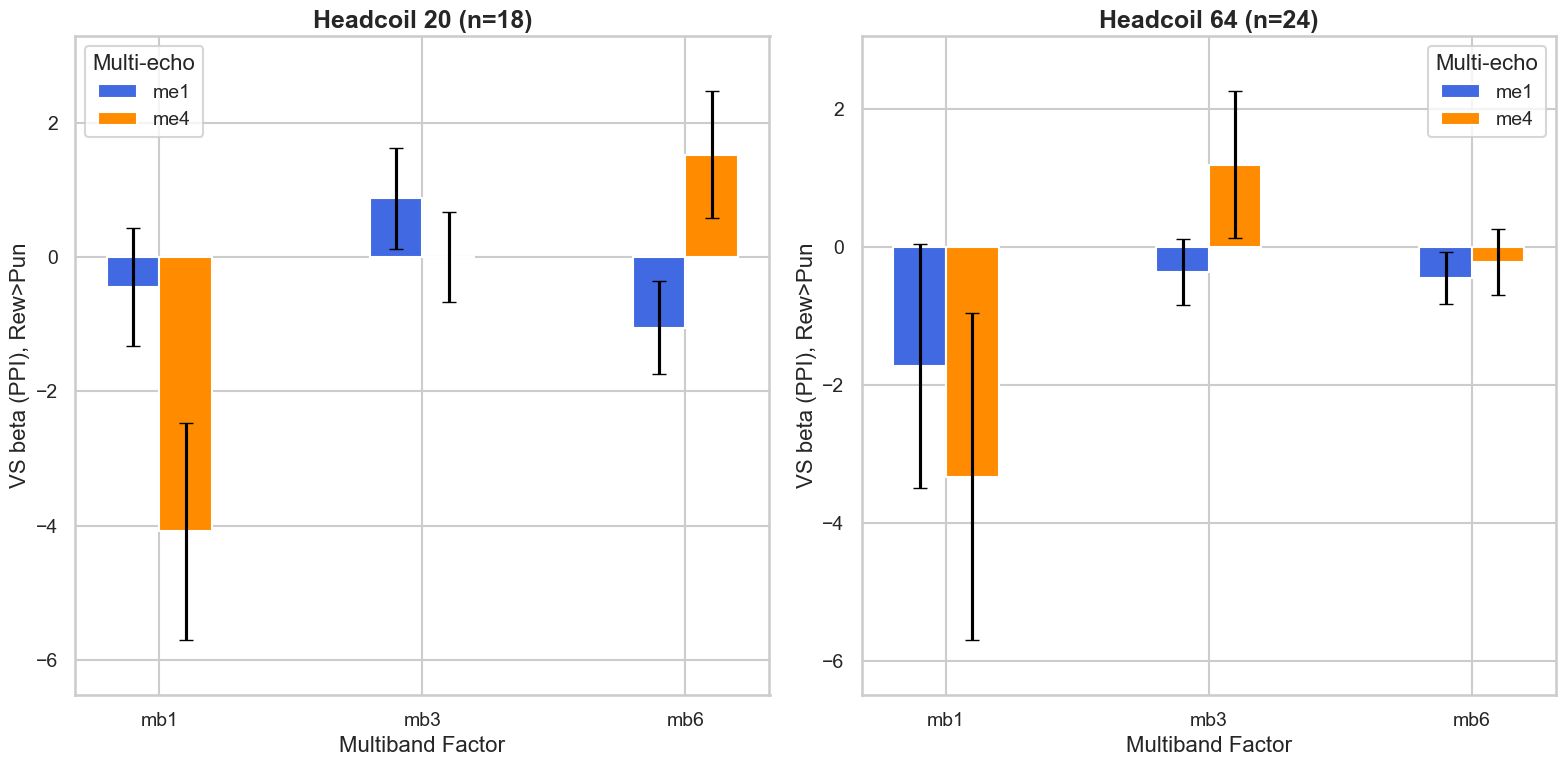

In [27]:
# VS PPI Rew>Pun, beta
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "ppi_seed-VS_thr5"  # e.g., "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta"  # e.g., "beta" "zstat" "tsnr"
MASK_VALUE = "VS"   # e.g., "VS" "VMPFC"
DENOISE_VALUE = "base"  # e.g., "base" "tedana"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    #print("Found files:", [os.path.basename(f) for f in file_paths]) # Debug line
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)

        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            #print(f"Matched: {filename} -> type={file_type}") # Debug line
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VS beta (PPI), Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        print("Debug: data_by_subject =", data_by_subject)  # Check its contents

        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

Processing files with parameters: type=ppi_seed-VS_thr5, img=zstat, mask=VS, denoise=base
Data saved to multiecho_data_ppi_seed-VS_thr5_zstat_VS_base.csv
Found data for 42 subjects

Sample of the data:
    subject  headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
14    10017        64 -0.173345 -0.182195 -0.124932 -0.094349  0.048616   
35    10024        64 -0.110746 -0.189748 -0.033504  0.182770  0.100844   
23    10035        64  0.164596 -0.187588 -0.373774  0.036821  0.287631   
27    10041        64 -0.193643  0.316890  0.066349 -0.167295 -0.092760   
38    10043        64 -0.204383 -0.034687  0.152701  0.055627 -0.036792   

      mb6me4  
14 -0.153370  
35 -0.016276  
23 -0.063559  
27 -0.158150  
38  0.000819  

Headcoil counts:
64-channel: 24
20-channel: 18

Creating bar plots...
Plot saved as 'multiecho_plots_ppi_seed-VS_thr5_zstat_VS_base.png'


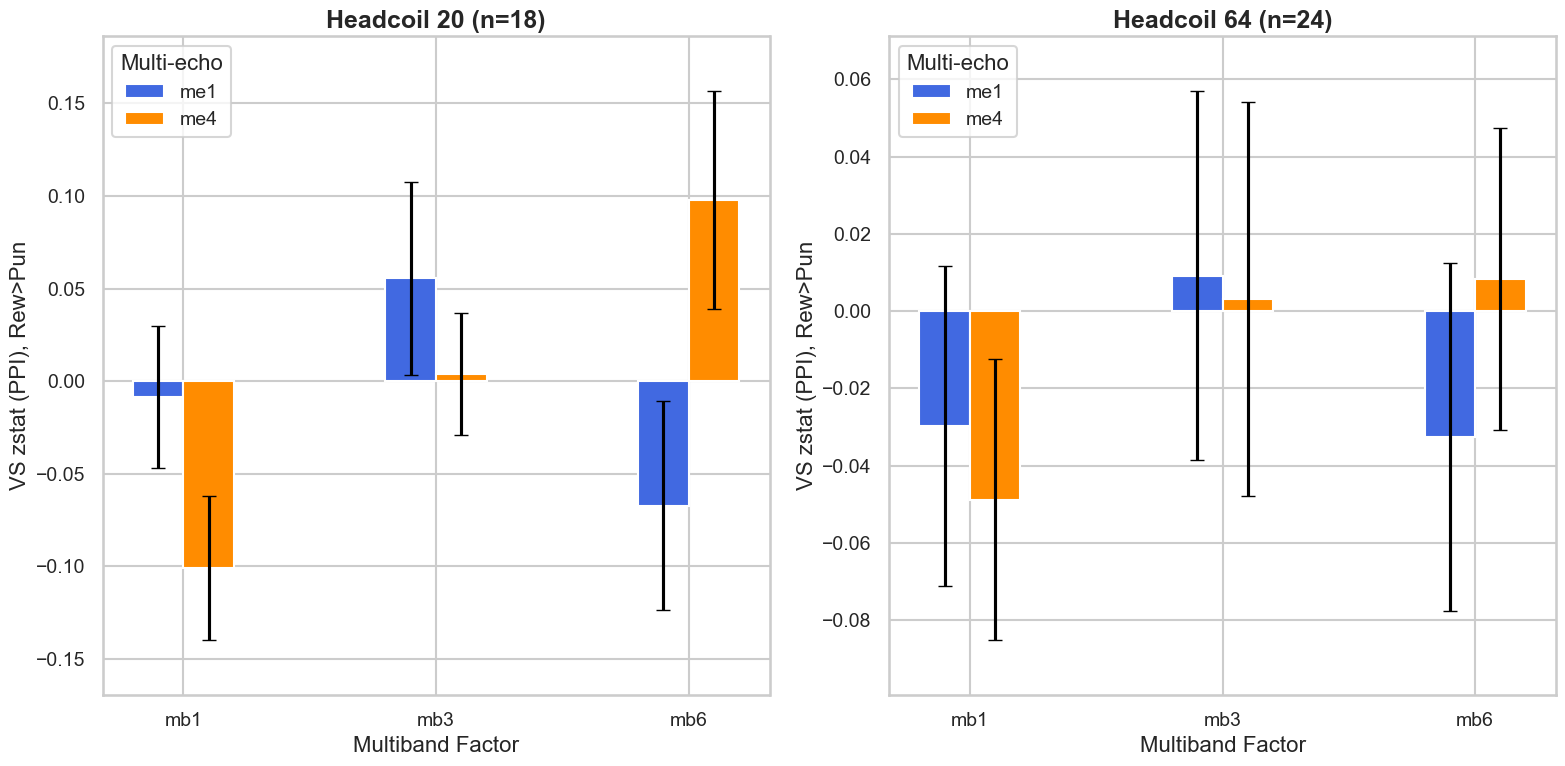

In [29]:
# VS PPI Rew>Pun, zstat
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "ppi_seed-VS_thr5"  # e.g., "act" "ppi_seed-VS_thr5"
IMG_VALUE = "zstat"  # e.g., "beta" "zstat" "tsnr"
MASK_VALUE = "VS"   # e.g., "VS" "VMPFC"
DENOISE_VALUE = "base"  # e.g., "base" "tedana"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    #print("Found files:", [os.path.basename(f) for f in file_paths]) # Debug line
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)

        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            #print(f"Matched: {filename} -> type={file_type}") # Debug line
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VS zstat (PPI), Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        print("Debug: data_by_subject =", data_by_subject)  # Check its contents

        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

Processing files with parameters: type=ppi_seed-VS_thr5, img=beta, mask=VMPFC, denoise=base
Data saved to multiecho_data_ppi_seed-VS_thr5_beta_VMPFC_base.csv
Found data for 42 subjects

Sample of the data:
    subject  headcoil     mb1me1     mb3me1    mb6me1     mb1me4    mb3me4  \
26    10017        64  89.017359  12.010323  4.497042  68.180398  8.784170   
2     10024        64  -6.226475  -0.769999  0.067973   8.666185  1.809777   
4     10035        64   4.883205  -5.489319 -3.194568  -1.606799 -3.248495   
29    10041        64  -4.631801   2.591177 -1.085837  -1.646030  3.895738   
32    10043        64  -3.732473   0.501781  1.528051   7.604556 -0.539567   

      mb6me4  
26  8.822580  
2  -0.687212  
4  -0.490057  
29 -2.318320  
32 -0.918568  

Headcoil counts:
64-channel: 24
20-channel: 18

Creating bar plots...
Plot saved as 'multiecho_plots_ppi_seed-VS_thr5_beta_VMPFC_base.png'


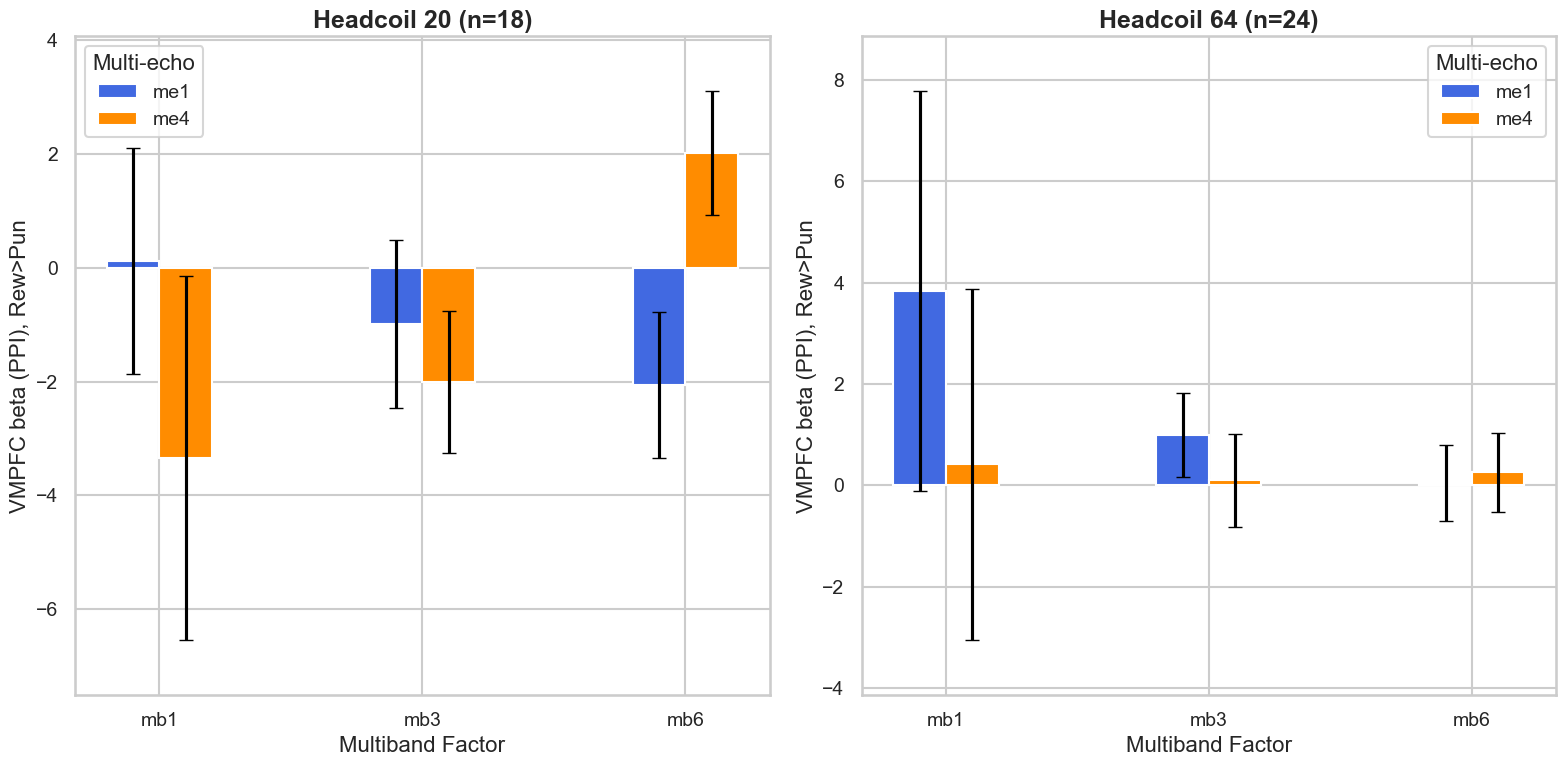

In [31]:
# VMPFC PPI Rew>Pun, beta
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "ppi_seed-VS_thr5"  # e.g., "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta"  # e.g., "beta" "zstat" "tsnr"
MASK_VALUE = "VMPFC"   # e.g., "VS" "VMPFC"
DENOISE_VALUE = "base"  # e.g., "base" "tedana"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    #print("Found files:", [os.path.basename(f) for f in file_paths]) # Debug line
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)

        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            #print(f"Matched: {filename} -> type={file_type}") # Debug line
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VMPFC beta (PPI), Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        print("Debug: data_by_subject =", data_by_subject)  # Check its contents

        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

Processing files with parameters: type=ppi_seed-VS_thr5, img=beta, mask=VMPFC, denoise=base
Data saved to multiecho_data_ppi_seed-VS_thr5_beta_VMPFC_base.csv
Found data for 42 subjects

Sample of the data:
    subject  headcoil     mb1me1     mb3me1    mb6me1     mb1me4    mb3me4  \
26    10017        64  89.017359  12.010323  4.497042  68.180398  8.784170   
2     10024        64  -6.226475  -0.769999  0.067973   8.666185  1.809777   
4     10035        64   4.883205  -5.489319 -3.194568  -1.606799 -3.248495   
29    10041        64  -4.631801   2.591177 -1.085837  -1.646030  3.895738   
32    10043        64  -3.732473   0.501781  1.528051   7.604556 -0.539567   

      mb6me4  
26  8.822580  
2  -0.687212  
4  -0.490057  
29 -2.318320  
32 -0.918568  

Headcoil counts:
64-channel: 24
20-channel: 18

Creating bar plots...
Plot saved as 'multiecho_plots_ppi_seed-VS_thr5_beta_VMPFC_base.png'


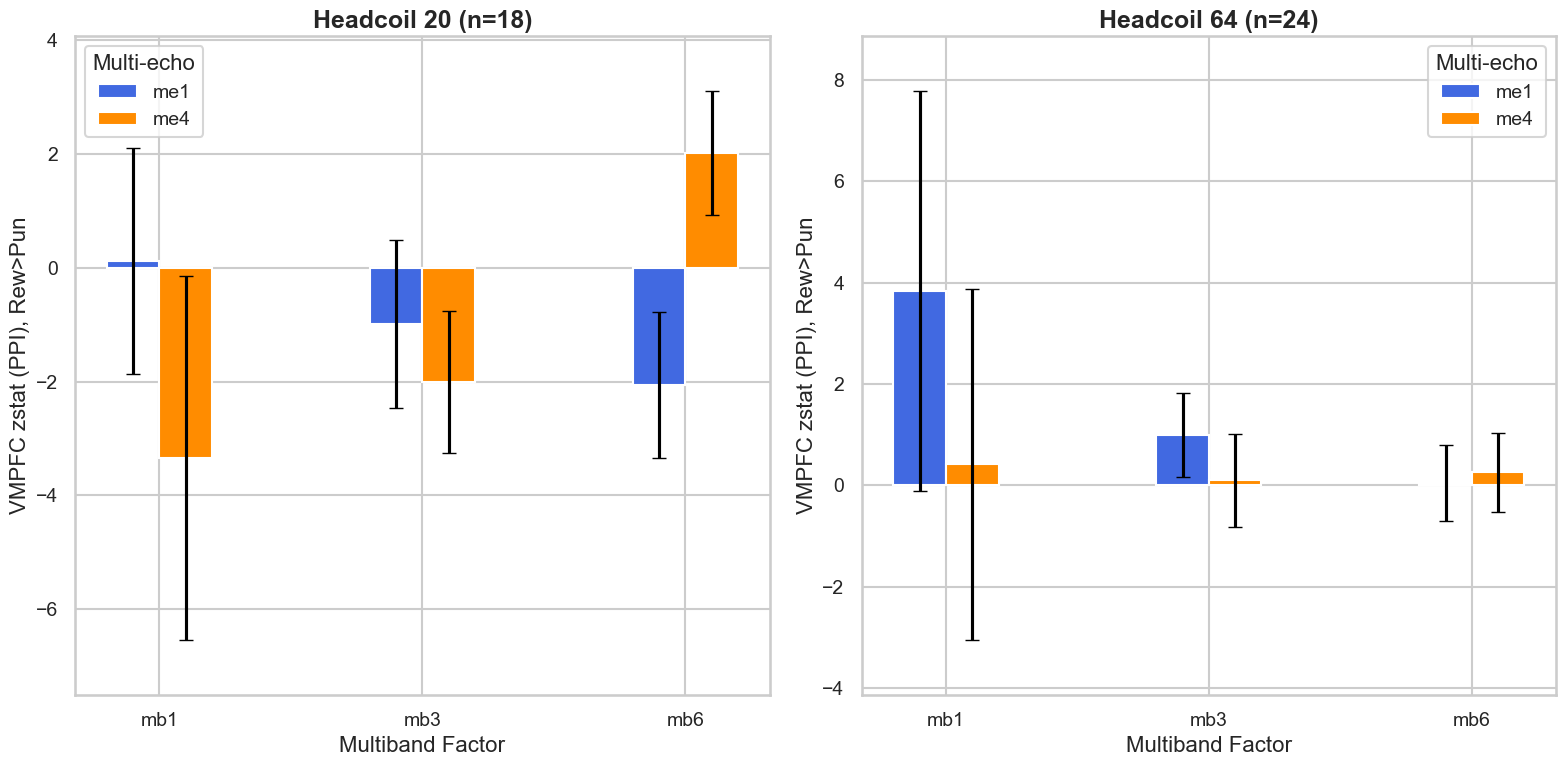

In [33]:
# VMPFC PPI Rew>Pun, zstat
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "ppi_seed-VS_thr5"  # e.g., "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta"  # e.g., "beta" "zstat" "tsnr"
MASK_VALUE = "VMPFC"   # e.g., "VS" "VMPFC"
DENOISE_VALUE = "base"  # e.g., "base" "tedana"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    #print("Found files:", [os.path.basename(f) for f in file_paths]) # Debug line
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)

        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            #print(f"Matched: {filename} -> type={file_type}") # Debug line
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VMPFC zstat (PPI), Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        print("Debug: data_by_subject =", data_by_subject)  # Check its contents

        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

In [41]:
# Generate avg fd_mean values for each ME acq
import pandas as pd

# Define file paths
input_file = "~/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv"
output_file = "~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv"

# Load the TSV file
df = pd.read_csv(input_file, sep="\t")

# Filter out subjects ending in 'sp' and acquisitions containing 'me1'
df = df[~df['Sub'].str.endswith('sp')]
df = df[~df['acq'].str.contains('me1', na=False)]

# Save the filtered DataFrame to a CSV file
df.to_csv(output_file, index=False)

#print("Filtered data saved to:", output_file)

import pandas as pd

# Load your spreadsheet data
df = pd.read_csv(output_file)

# Extract the base 'acq' substring (e.g., mb1me4, mb3me4, mb6me4) from the 'acq' column
df['acq_base'] = df['acq'].str.extract(r'(mb\dme4)')

# Group by 'Sub' and 'acq_base' and calculate the average of 'fd_mean' for each group
averages = df.groupby(['Sub', 'acq_base'])['fd_mean'].mean().reset_index()

# Save the results to a new spreadsheet
output_file_path = 'fd_mean_averages.xlsx'  # Replace with your desired output file path
averages.to_excel(output_file_path, index=False)

# Optionally, print the averages to verify
print(averages)


          Sub acq_base   fd_mean
0   sub-10017   mb1me4  0.065809
1   sub-10017   mb3me4  0.093968
2   sub-10017   mb6me4  0.087372
3   sub-10028   mb1me4  0.043817
4   sub-10028   mb3me4  0.082697
..        ...      ...       ...
86  sub-10716   mb3me4  0.579043
87  sub-10738   mb1me4  0.326083
88  sub-12042   mb1me4  0.091052
89  sub-12042   mb3me4  0.103584
90  sub-12042   mb6me4  0.100240

[91 rows x 3 columns]


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

def load_txt_data(denoise):
    """Load values from .txt files based on denoising type."""
    file_pattern = f"~/Documents/GitHub/multiecho-pilot/data/*_{denoise}.txt"
    file_list = glob.glob(os.path.expanduser(file_pattern))
    
    data = {}
    for file in file_list:
        subject, acq, _ = os.path.basename(file).split('_')  # Extract subject & acq
        if acq not in ["mb1me4", "mb3me4", "mb6me4"]:
            continue  # Only keep multiecho acquisitions
        
        with open(file, 'r') as f:
            value = float(f.read().strip())
        
        if subject not in data:
            data[subject] = {}
        data[subject][acq] = value
    
    return data

def compute_differences():
    """Compute tedana - base differences for each subject and acquisition."""
    base_values = load_txt_data("base")
    tedana_values = load_txt_data("tedana")
    
    difference_values = {}
    for sub in tedana_values:
        if sub in base_values:
            difference_values[sub] = {}
            for acq in tedana_values[sub]:
                if acq in base_values[sub]:
                    difference_values[sub][acq] = tedana_values[sub][acq] - base_values[sub][acq]
    
    return difference_values

def create_dataframe(differences):
    """Convert difference values to a DataFrame."""
    rows = []
    for sub, acqs in differences.items():
        for acq, diff_value in acqs.items():
            rows.append({"subject": sub, "acquisition": acq, "tedana_base_diff": diff_value})
    
    return pd.DataFrame(rows)

def process_and_visualize():
    print("Processing data for tedana-base comparison...")
    
    # Compute differences
    differences = compute_differences()
    df = create_dataframe(differences)
    
    # Load fd_mean values
    fd_df = pd.read_csv("~/Documents/GitHub/multiecho-pilot/code/fd_mean_averages.csv")
    
    # Merge fd_mean values into df
    df = df.merge(fd_df, on=["subject", "acq"], how="left")
    
    # Save to CSV
    output_file = "tedana_vs_base_differences.csv"
    df.to_csv(output_file, index=False)
    print(f"Data saved to {output_file}")
    
    # Generate scatter plots
    print("Creating scatter plots...")
    for acq in df["acquisition"].unique():
        subset = df[df["acquisition"] == acq]
        plt.figure()
        plt.scatter(subset["fd_mean"], subset["tedana_base_diff"], alpha=0.7)
        plt.xlabel("fd_mean")
        plt.ylabel("tedana - base difference")
        plt.title(f"{acq} - Tedana vs. Base Difference vs. fd_mean")
        plt.grid(True)
        plt.savefig(f"scatterplot_{acq}.png", dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Scatter plot saved: scatterplot_{acq}.png")
    
    return df

if __name__ == "__main__":
    df = process_and_visualize()



Processing data for tedana-base comparison...


KeyError: 'subject'